```
\copy ( SELECT s.source_file_acquisition, COUNT(s.packet_id) FROM (SELECT DISTINCT source_file_acquisition, packet_id FROM spb_processing_v4_flatmap."event" WHERE source_data_type_num=1 ORDER BY source_file_acquisition ASC) AS s GROUP BY s.source_file_acquisition ORDER BY s.source_file_acquisition ASC ) TO '/mnt/data_wdblue3d1/stuff/spb_processing_v4_flatmap_event_packet_count_by_file_20190618.txt' with csv header delimiter as E'\t';
```

```
less /mnt/data_wdblue3d1/stuff/spb_processing_v4_flatmap_event_packet_count_by_file.txt
less /home/spbproc/SPBDATA_flight/count_tevent_entries.txt 
cut -f1 /home/spbproc/SPBDATA_flight/count_tevent_entries.txt | head
cut -f2 /home/spbproc/SPBDATA_flight/count_tevent_entries.txt | head
cut -f2 /home/spbproc/SPBDATA_flight/count_tevent_entries.txt | head | xargs -n1 -I{} echo '{}/128' | bc
f=/home/spbproc/SPBDATA_flight/count_tevent_entries.txt; paste <(cut -f1 "$f")  <(cut -f2 "$f" | xargs -n1 -I{} echo '{}/128' | bc) | tee /home/spbproc/SPBDATA_flight/count_tevent_packets.txt
diff -y -W 400 /mnt/data_wdblue3d1/stuff/spb_processing_v4_flatmap_event_packet_count_by_file.txt /home/spbproc/SPBDATA_flight/count_tevent_packets.txt
diff -y -W 200 /mnt/data_wdblue3d1/stuff/spb_processing_v4_flatmap_event_packet_count_by_file.txt /home/spbproc/SPBDATA_flight/count_tevent_packets.txt | less
meld /mnt/data_wdblue3d1/stuff/spb_processing_v4_flatmap_event_packet_count_by_file.txt /home/spbproc/SPBDATA_flight/count_tevent_packets.txt 
f=/home/spbproc/SPBDATA_flight/count_tevent_entries.txt; paste <(cut -f1 "$f" | xargs -l1 basename)  <(cut -f2 "$f" | xargs -n1 -I{} echo '{}/128' | bc) | tee /home/spbproc/SPBDATA_flight/count_sfa_tevent_packets.txt
meld /mnt/data_wdblue3d1/stuff/spb_processing_v4_flatmap_event_packet_count_by_file.txt /home/spbproc/SPBDATA_flight/count_sfa_tevent_packets.txt 
meld /mnt/data_wdblue3d1/stuff/spb_processing_v4_flatmap_event_packet_count_by_file.txt /home/spbproc/SPBDATA_flight/count_sfa_tevent_packets.txt 
meld <(sort -f /mnt/data_wdblue3d1/stuff/spb_processing_v4_flatmap_event_packet_count_by_file.txt) <(sort -h /home/spbproc/SPBDATA_flight/count_sfa_tevent_packets.txt)
tail -n+2 /mnt/data_wdblue3d1/stuff/spb_processing_v4_flatmap_event_packet_count_by_file.txt | head
meld <(tail -n+2 /mnt/data_wdblue3d1/stuff/spb_processing_v4_flatmap_event_packet_count_by_file.txt | sort -h) <(sort -h /home/spbproc/SPBDATA_flight/count_sfa_tevent_packets.txt)
```

In [1]:
import sys
import subprocess
import pandas as pd
import matplotlib.pyplot as plt
import re
import datetime
import os

In [2]:
data_snippets_dir = 'flight_data_packet_count_comparison_20190618'
os.makedirs(data_snippets_dir, exist_ok=True)

In [3]:
filename_datetime_re = re.compile(
    r'(\d{4})(\d\d)(\d\d)-(\d\d)(\d\d)(\d\d)-(\d+)\.(\d+)-+(LONG|CHECK|)(-sqz(-dis)?)?\.root$')


def parse_acq_filename(infile):
    m = filename_datetime_re.search(infile)
    if m:
        bunch = int(m.group(7))
        mode = m.group(9)
        datetime_step = datetime.datetime(
            year=int(m.group(1)), month=int(m.group(2)), day=int(m.group(3)),
            hour=int(m.group(4)), minute=int(m.group(5)), second=int(m.group(6))
        )
        step_timedelta = datetime.timedelta(seconds=0)
        if mode == 'LONG':
            step_timedelta = datetime.timedelta(seconds=120)
        elif mode == 'CHECK':
            step_timedelta = datetime.timedelta(seconds=40)
        datetime_step_modified = datetime_step + step_timedelta * (bunch - 1)
        return bunch, mode, step_timedelta, datetime_step, datetime_step_modified
    return None

def parse_acq_filename_datetime_modified(infile):
    t = parse_acq_filename(infile)
    if t is None:
        return None
    else:
        return t[3]

In [4]:
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows', 500)

In [5]:
db_df = pd.read_csv('/mnt/data_wdblue3d1/stuff/spb_processing_v4_flatmap_event_packet_count_by_file_20190618.txt', sep='\t')
files_df = pd.read_csv('/home/spbproc/SPBDATA_flight/count_sfa_tevent_packets_20190618.txt', sep='\t',
                       names=['source_file_acquisition', 'count'])

In [6]:
db_df['datetime'] = db_df['source_file_acquisition'].apply(parse_acq_filename_datetime_modified)
files_df['datetime'] = files_df['source_file_acquisition'].apply(parse_acq_filename_datetime_modified)

In [7]:
files_df.query('source_file_acquisition  =="allpackets-SPBEUSO-ACQUISITION-20170427-162053-001.001--.root"')

,source_file_acquisition,count,datetime
273,allpackets-SPBEUSO-ACQUISITION-20170427-162053-001.001--.root,5,2017-04-27 16:20:53


In [8]:
# =="allpackets-SPBEUSO-ACQUISITION-20170427-162053-001.001--.root"
files_df[files_df['datetime'].isnull()]

,source_file_acquisition,count,datetime


In [9]:
db_df.head()

,source_file_acquisition,count,datetime
0,allpackets-SPBEUSO-ACQUISITION-20170420-135400-001.001--CHECK.root,201,2017-04-20 13:54:00
1,allpackets-SPBEUSO-ACQUISITION-20170420-135444-002.001--LONG.root,284,2017-04-20 13:54:44
2,allpackets-SPBEUSO-ACQUISITION-20170420-135444-006.001--LONG.root,79,2017-04-20 13:54:44
3,allpackets-SPBEUSO-ACQUISITION-20170420-160356-001.001--CHECK.root,12,2017-04-20 16:03:56
4,allpackets-SPBEUSO-ACQUISITION-20170420-160440-001.001--LONG.root,36,2017-04-20 16:04:40


In [10]:
files_df.head()

,source_file_acquisition,count,datetime
0,allpackets-SPBEUSO-ACQUISITION-20170420-135400-001.001--CHECK.root,219,2017-04-20 13:54:00
1,allpackets-SPBEUSO-ACQUISITION-20170420-135444-002.001--LONG.root,304,2017-04-20 13:54:44
2,allpackets-SPBEUSO-ACQUISITION-20170420-135444-006.001--LONG.root,86,2017-04-20 13:54:44
3,allpackets-SPBEUSO-ACQUISITION-20170420-160356-001.001--CHECK.root,34,2017-04-20 16:03:56
4,allpackets-SPBEUSO-ACQUISITION-20170420-160440-001.001--LONG.root,110,2017-04-20 16:04:40


In [11]:
merged_df = pd.merge(db_df, files_df, on='source_file_acquisition', how='outer', indicator=True, 
                     suffixes=('_in_db', '_in_files'))

In [12]:
merged_df.head()

,source_file_acquisition,count_in_db,datetime_in_db,count_in_files,datetime_in_files,_merge
0,allpackets-SPBEUSO-ACQUISITION-20170420-135400-001.001--CHECK.root,201.0,2017-04-20 13:54:00,219,2017-04-20 13:54:00,both
1,allpackets-SPBEUSO-ACQUISITION-20170420-135444-002.001--LONG.root,284.0,2017-04-20 13:54:44,304,2017-04-20 13:54:44,both
2,allpackets-SPBEUSO-ACQUISITION-20170420-135444-006.001--LONG.root,79.0,2017-04-20 13:54:44,86,2017-04-20 13:54:44,both
3,allpackets-SPBEUSO-ACQUISITION-20170420-160356-001.001--CHECK.root,12.0,2017-04-20 16:03:56,34,2017-04-20 16:03:56,both
4,allpackets-SPBEUSO-ACQUISITION-20170420-160440-001.001--LONG.root,36.0,2017-04-20 16:04:40,110,2017-04-20 16:04:40,both


## Database - filesystem: Same counts 

In [13]:
same_counts_df =  merged_df.query('count_in_db == count_in_files')

In [14]:
same_counts_df

,source_file_acquisition,count_in_db,datetime_in_db,count_in_files,datetime_in_files,_merge
23,allpackets-SPBEUSO-ACQUISITION-20170425-085641-001.001--CHECK.root,50.0,2017-04-25 08:56:41,50,2017-04-25 08:56:41,both
49,allpackets-SPBEUSO-ACQUISITION-20170425-122821-001.001--LONG.root,21.0,2017-04-25 12:28:21,21,2017-04-25 12:28:21,both
50,allpackets-SPBEUSO-ACQUISITION-20170425-122850-001.001--LONG.root,14.0,2017-04-25 12:28:50,14,2017-04-25 12:28:50,both
52,allpackets-SPBEUSO-ACQUISITION-20170425-123151-001.001--CHECK.root,26.0,2017-04-25 12:31:51,26,2017-04-25 12:31:51,both
60,allpackets-SPBEUSO-ACQUISITION-20170426-125845-001.001--CHECK.root,12.0,2017-04-26 12:58:45,12,2017-04-26 12:58:45,both
61,allpackets-SPBEUSO-ACQUISITION-20170426-125930-001.001--LONG.root,34.0,2017-04-26 12:59:30,34,2017-04-26 12:59:30,both
62,allpackets-SPBEUSO-ACQUISITION-20170426-125930-002.001--LONG.root,41.0,2017-04-26 12:59:30,41,2017-04-26 12:59:30,both
63,allpackets-SPBEUSO-ACQUISITION-20170426-125930-003.001--LONG.root,53.0,2017-04-26 12:59:30,53,2017-04-26 12:59:30,both
64,allpackets-SPBEUSO-ACQUISITION-20170426-125930-004.001--LONG.root,36.0,2017-04-26 12:59:30,36,2017-04-26 12:59:30,both
258,allpackets-SPBEUSO-ACQUISITION-20170427-162053-001.001--.root,5.0,2017-04-27 16:20:53,5,2017-04-27 16:20:53,both


In [15]:
len(same_counts_df)

92

## Database - filesystem: Different counts 

In [128]:
 (merged_df['count_in_db'] != merged_df['count_in_files']) & (merged_df['_merge']=='both')

,source_file_acquisition,count_in_db,datetime_in_db,count_in_files,datetime_in_files,_merge,count_difference,count_difference_fraction
0,allpackets-SPBEUSO-ACQUISITION-20170420-135400-001.001--CHECK.root,201.0,2017-04-20 13:54:00,219,2017-04-20 13:54:00,both,18.0,1.0
1,allpackets-SPBEUSO-ACQUISITION-20170420-135444-002.001--LONG.root,284.0,2017-04-20 13:54:44,304,2017-04-20 13:54:44,both,20.0,1.0
2,allpackets-SPBEUSO-ACQUISITION-20170420-135444-006.001--LONG.root,79.0,2017-04-20 13:54:44,86,2017-04-20 13:54:44,both,7.0,1.0
3,allpackets-SPBEUSO-ACQUISITION-20170420-160356-001.001--CHECK.root,12.0,2017-04-20 16:03:56,34,2017-04-20 16:03:56,both,22.0,1.0
4,allpackets-SPBEUSO-ACQUISITION-20170420-160440-001.001--LONG.root,36.0,2017-04-20 16:04:40,110,2017-04-20 16:04:40,both,74.0,1.0
5,allpackets-SPBEUSO-ACQUISITION-20170420-160440-002.001--LONG.root,29.0,2017-04-20 16:04:40,101,2017-04-20 16:04:40,both,72.0,1.0
6,allpackets-SPBEUSO-ACQUISITION-20170421-135909-001.001--CHECK.root,229.0,2017-04-21 13:59:09,306,2017-04-21 13:59:09,both,77.0,1.0
7,allpackets-SPBEUSO-ACQUISITION-20170424-150143-001.001--CHECK.root,4.0,2017-04-24 15:01:43,13,2017-04-24 15:01:43,both,9.0,1.0
8,allpackets-SPBEUSO-ACQUISITION-20170424-150228-001.001--LONG.root,21.0,2017-04-24 15:02:28,76,2017-04-24 15:02:28,both,55.0,1.0
9,allpackets-SPBEUSO-ACQUISITION-20170424-150228-002.001--LONG.root,26.0,2017-04-24 15:02:28,69,2017-04-24 15:02:28,both,43.0,1.0


In [148]:
merged_df['count_difference'] = merged_df['count_in_files']
merged_df['count_difference_fraction'] = 1

different_counts_mask = (merged_df['count_in_db'] != merged_df['count_in_files']) & (merged_df['_merge']=='both')

merged_df.loc[different_counts_mask, 'count_difference'] = (merged_df[different_counts_mask]['count_in_files'] - merged_df[different_counts_mask]['count_in_db'])
# merged_df.loc[different_counts_mask, 'count_difference_fraction'] = different_counts_df['count_difference'] / different_counts_df['count_in_files']
merged_df['count_difference_fraction'] = merged_df['count_difference'] / merged_df['count_in_files']

different_counts_df = merged_df[different_counts_mask]

In [149]:
merged_df.head(80)

,source_file_acquisition,count_in_db,datetime_in_db,count_in_files,datetime_in_files,_merge,count_difference,count_difference_fraction
0,allpackets-SPBEUSO-ACQUISITION-20170420-135400-001.001--CHECK.root,201.0,2017-04-20 13:54:00,219,2017-04-20 13:54:00,both,18.0,0.082192
1,allpackets-SPBEUSO-ACQUISITION-20170420-135444-002.001--LONG.root,284.0,2017-04-20 13:54:44,304,2017-04-20 13:54:44,both,20.0,0.065789
2,allpackets-SPBEUSO-ACQUISITION-20170420-135444-006.001--LONG.root,79.0,2017-04-20 13:54:44,86,2017-04-20 13:54:44,both,7.0,0.081395
3,allpackets-SPBEUSO-ACQUISITION-20170420-160356-001.001--CHECK.root,12.0,2017-04-20 16:03:56,34,2017-04-20 16:03:56,both,22.0,0.647059
4,allpackets-SPBEUSO-ACQUISITION-20170420-160440-001.001--LONG.root,36.0,2017-04-20 16:04:40,110,2017-04-20 16:04:40,both,74.0,0.672727
5,allpackets-SPBEUSO-ACQUISITION-20170420-160440-002.001--LONG.root,29.0,2017-04-20 16:04:40,101,2017-04-20 16:04:40,both,72.0,0.712871
6,allpackets-SPBEUSO-ACQUISITION-20170421-135909-001.001--CHECK.root,229.0,2017-04-21 13:59:09,306,2017-04-21 13:59:09,both,77.0,0.251634
7,allpackets-SPBEUSO-ACQUISITION-20170424-150143-001.001--CHECK.root,4.0,2017-04-24 15:01:43,13,2017-04-24 15:01:43,both,9.0,0.692308
8,allpackets-SPBEUSO-ACQUISITION-20170424-150228-001.001--LONG.root,21.0,2017-04-24 15:02:28,76,2017-04-24 15:02:28,both,55.0,0.723684
9,allpackets-SPBEUSO-ACQUISITION-20170424-150228-002.001--LONG.root,26.0,2017-04-24 15:02:28,69,2017-04-24 15:02:28,both,43.0,0.623188


In [150]:
len(different_counts_df)

960

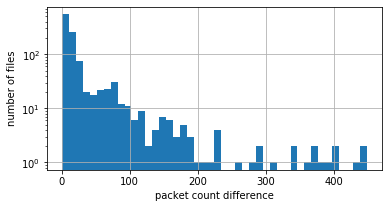

In [167]:
fig, ax = plt.subplots(figsize=(6,3))
merged_df['count_difference'].hist(ax=ax, bins=int(merged_df['count_difference'].max()//10))
ax.set_xlabel('packet count difference')
ax.set_ylabel('number of files')
ax.set_yscale('log')
fig.savefig(os.path.join(data_snippets_dir, 'count_difference_distribution.svg'), dpi=150)
plt.show()

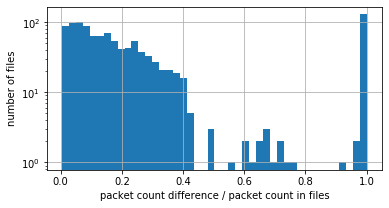

In [165]:
fig, ax = plt.subplots(figsize=(6,3))
merged_df['count_difference_fraction'].hist(ax=ax, bins=int(merged_df['count_difference'].max()//10))
ax.set_xlabel('packet count difference / packet count in files')
ax.set_ylabel('number of files')
ax.set_yscale('log')
fig.savefig(os.path.join(data_snippets_dir, 'count_difference_fraction_distribution.svg'), dpi=150)
plt.show()

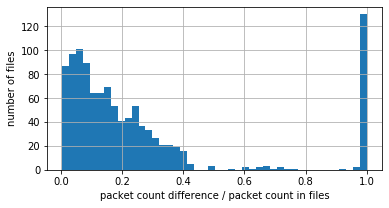

In [172]:
fig, ax = plt.subplots(figsize=(6,3))
merged_df['count_difference_fraction'].hist(ax=ax, bins=int(merged_df['count_difference'].max()//10))
ax.set_xlabel('packet count difference / packet count in files')
ax.set_ylabel('number of files')
# ax.set_yscale('log')
fig.savefig(os.path.join(data_snippets_dir, 'count_difference_fraction_distribution_linea.svg'), dpi=150)
plt.show()

In [168]:
different_counts_df.sort_values('count_difference_fraction', ascending=False).head(200)

,source_file_acquisition,count_in_db,datetime_in_db,count_in_files,datetime_in_files,_merge,count_difference,count_difference_fraction
526,allpackets-SPBEUSO-ACQUISITION-20170429-100343-014.001--LONG-sqz.root,4.0,2017-04-29 10:03:43,147,2017-04-29 10:03:43,both,143.0,0.972789
532,allpackets-SPBEUSO-ACQUISITION-20170429-100343-022.001--LONG-sqz.root,5.0,2017-04-29 10:03:43,115,2017-04-29 10:03:43,both,110.0,0.956522
18,allpackets-SPBEUSO-ACQUISITION-20170424-172427-005.001--LONG.root,2.0,2017-04-24 17:24:27,26,2017-04-24 17:24:27,both,24.0,0.923077
17,allpackets-SPBEUSO-ACQUISITION-20170424-172427-004.001--LONG.root,24.0,2017-04-24 17:24:27,98,2017-04-24 17:24:27,both,74.0,0.755102
15,allpackets-SPBEUSO-ACQUISITION-20170424-172427-002.001--LONG.root,20.0,2017-04-24 17:24:27,80,2017-04-24 17:24:27,both,60.0,0.750000
8,allpackets-SPBEUSO-ACQUISITION-20170424-150228-001.001--LONG.root,21.0,2017-04-24 15:02:28,76,2017-04-24 15:02:28,both,55.0,0.723684
5,allpackets-SPBEUSO-ACQUISITION-20170420-160440-002.001--LONG.root,29.0,2017-04-20 16:04:40,101,2017-04-20 16:04:40,both,72.0,0.712871
7,allpackets-SPBEUSO-ACQUISITION-20170424-150143-001.001--CHECK.root,4.0,2017-04-24 15:01:43,13,2017-04-24 15:01:43,both,9.0,0.692308
4,allpackets-SPBEUSO-ACQUISITION-20170420-160440-001.001--LONG.root,36.0,2017-04-20 16:04:40,110,2017-04-20 16:04:40,both,74.0,0.672727
13,allpackets-SPBEUSO-ACQUISITION-20170424-172343-001.001--CHECK.root,7.0,2017-04-24 17:23:43,21,2017-04-24 17:23:43,both,14.0,0.666667


In [169]:
different_counts_df.sort_values('count_difference', ascending=False).head(200)

,source_file_acquisition,count_in_db,datetime_in_db,count_in_files,datetime_in_files,_merge,count_difference,count_difference_fraction
116,allpackets-SPBEUSO-ACQUISITION-20170427-082554-002.001--LONG-sqz.root,776.0,2017-04-27 08:25:54,1224,2017-04-27 08:25:54,both,448.0,0.366013
115,allpackets-SPBEUSO-ACQUISITION-20170427-082554-001.001--LONG-sqz.root,761.0,2017-04-27 08:25:54,1203,2017-04-27 08:25:54,both,442.0,0.367415
117,allpackets-SPBEUSO-ACQUISITION-20170427-082554-003.001--LONG-sqz.root,714.0,2017-04-27 08:25:54,1149,2017-04-27 08:25:54,both,435.0,0.378590
119,allpackets-SPBEUSO-ACQUISITION-20170427-082554-005.001--LONG-sqz.root,735.0,2017-04-27 08:25:54,1135,2017-04-27 08:25:54,both,400.0,0.352423
121,allpackets-SPBEUSO-ACQUISITION-20170427-082554-007.001--LONG-sqz.root,583.0,2017-04-27 08:25:54,982,2017-04-27 08:25:54,both,399.0,0.406314
123,allpackets-SPBEUSO-ACQUISITION-20170427-082554-008.001--LONG-sqz.root,614.0,2017-04-27 08:25:54,1008,2017-04-27 08:25:54,both,394.0,0.390873
125,allpackets-SPBEUSO-ACQUISITION-20170427-082554-010.001--LONG-sqz.root,639.0,2017-04-27 08:25:54,1016,2017-04-27 08:25:54,both,377.0,0.371063
118,allpackets-SPBEUSO-ACQUISITION-20170427-082554-004.001--LONG-sqz.root,667.0,2017-04-27 08:25:54,1041,2017-04-27 08:25:54,both,374.0,0.359270
120,allpackets-SPBEUSO-ACQUISITION-20170427-082554-006.001--LONG-sqz.root,659.0,2017-04-27 08:25:54,1030,2017-04-27 08:25:54,both,371.0,0.360194
129,allpackets-SPBEUSO-ACQUISITION-20170427-105159-002.001--LONG-sqz.root,529.0,2017-04-27 10:51:59,887,2017-04-27 10:51:59,both,358.0,0.403608


In [170]:
different_counts_df['count_difference'].sum() 

28989.0

In [171]:
different_counts_df[different_counts_df['datetime_in_files'] > datetime.datetime(year=2017, day=25, month=4)]['count_difference'].sum()

28192.0

allpackets-SPBEUSO-ACQUISITION-20170429-100343-014.001--LONG-sqz.root
- nothing triggered after packet 4, same sequence of frames

allpackets-SPBEUSO-ACQUISITION-20170429-100343-022.001--LONG-sqz.root
- same sequence of frames after 3

## Database - filesystem: Only database

In [25]:
only_db_counts_df = merged_df.query('_merge=="left_only"')

In [26]:
len(only_db_counts_df)

0

In [27]:
only_db_counts_df

,source_file_acquisition,count_in_db,datetime_in_db,count_in_files,datetime_in_files,_merge


## Database - filesystem: Only filesystem

In [28]:
only_files_counts_df = merged_df.query('_merge=="right_only"')

In [29]:
len(only_files_counts_df)

38

In [30]:
only_files_counts_df

,source_file_acquisition,count_in_db,datetime_in_db,count_in_files,datetime_in_files,_merge
1052,allpackets-SPBEUSO-ACQUISITION-20170425-122743-001.001--CHECK.root,NaN,NaT,1,2017-04-25 12:27:43,right_only
1053,allpackets-SPBEUSO-ACQUISITION-20170425-122750-001.001--LONG.root,NaN,NaT,1,2017-04-25 12:27:50,right_only
1054,allpackets-SPBEUSO-ACQUISITION-20170425-122814-001.001--CHECK.root,NaN,NaT,1,2017-04-25 12:28:14,right_only
1055,allpackets-SPBEUSO-ACQUISITION-20170425-122842-001.001--CHECK.root,NaN,NaT,1,2017-04-25 12:28:42,right_only
1056,allpackets-SPBEUSO-ACQUISITION-20170427-105159-010.001--LONG-sqz-dis.root,NaN,NaT,1,2017-04-27 10:51:59,right_only
1057,allpackets-SPBEUSO-ACQUISITION-20170427-105159-010.001--LONG-sqz.root,NaN,NaT,289,2017-04-27 10:51:59,right_only
1058,allpackets-SPBEUSO-ACQUISITION-20170427-125407-027.001--LONG-sqz.root,NaN,NaT,1,2017-04-27 12:54:07,right_only
1059,allpackets-SPBEUSO-ACQUISITION-20170427-152415-001.001--CHECK.root,NaN,NaT,1,2017-04-27 15:24:15,right_only
1060,allpackets-SPBEUSO-ACQUISITION-20170427-152446-001.001--CHECK.root,NaN,NaT,1,2017-04-27 15:24:46,right_only
1061,allpackets-SPBEUSO-ACQUISITION-20170427-152514-001.001--CHECK.root,NaN,NaT,1,2017-04-27 15:25:14,right_only


In [83]:
sum([c for c in only_files_counts_df['count_in_files'] if c == 1])

34

In [84]:
sum([c for c in only_files_counts_df['count_in_files'] if c > 1])

597

In [31]:
only_files_counts_df['count_in_files'].sum()

631

every packet everything exactly same sequence, nothing triggered
- allpackets-SPBEUSO-ACQUISITION-20170429-100343-003.001--LONG-sqz.root
- allpackets-SPBEUSO-ACQUISITION-20170429-070031-007.001--LONG-sqz.root
- allpackets-SPBEUSO-ACQUISITION-20170427-105159-010.001--LONG-sqz.root
- allpackets-SPBEUSO-ACQUISITION-20170429-070031-003.001--LONG-sqz.root


## Non-processed packets

In [85]:
num_non_processed_packets_large_files = sum([c for c in only_files_counts_df['count_in_files'] if c > 1])
num_non_processed_different_packets = different_counts_df['count_difference'].sum() + num_non_processed_packets_large_files
num_non_processed_files_packets = only_files_counts_df['count_in_files'].sum() - num_non_processed_packets_large_files
num_non_processed_packets = num_non_processed_different_packets + num_non_processed_files_packets

### All

In [86]:
num_non_processed_packets

29620.0

In [87]:
num_non_processed_different_packets

29586.0

In [88]:
num_non_processed_files_packets

34

In [89]:
db_df['count'].sum()

148327

In [90]:
files_df['count'].sum()

177947

In [91]:
db_df['count'].sum() / files_df['count'].sum()

0.8335459434550737

In [92]:
1 - db_df['count'].sum() / files_df['count'].sum()

0.1664540565449263

In [93]:
num_non_processed_packets / files_df['count'].sum()

0.1664540565449263

In [94]:
num_non_processed_files_packets / files_df['count'].sum()

0.00019106812702658656

In [95]:
num_non_processed_different_packets / files_df['count'].sum()

0.16626298841789972

In [96]:
 files_df['count'].sum() * 128 * 2.5 * 10**(-6)

56.943039999999996

### After start

In [100]:
start_datetime = datetime.datetime(year=2017, day=25, month=4)

num_non_processed_packets_large_files_after_start = \
    sum([c for c in only_files_counts_df[only_files_counts_df['datetime_in_files'] > start_datetime]['count_in_files'] if c > 1])
num_non_processed_different_packets_after_start = \
    different_counts_df[different_counts_df['datetime_in_files'] > start_datetime]['count_difference'].sum() \
    + num_non_processed_packets_large_files_after_start
num_non_processed_files_packets_after_start = \
    only_files_counts_df[only_files_counts_df['datetime_in_files'] > start_datetime]['count_in_files'].sum() \
    - num_non_processed_packets_large_files_after_start
num_non_processed_packets_after_start = \
    num_non_processed_different_packets_after_start + num_non_processed_files_packets_after_start

db_after_start_df = db_df[db_df['datetime'] > start_datetime]
files_after_start_df = files_df[files_df['datetime'] > start_datetime]

In [101]:
num_non_processed_packets_after_start

28823.0

In [102]:
num_non_processed_different_packets_after_start

28789.0

In [103]:
num_non_processed_files_packets_after_start

34

In [104]:
db_after_start_df['count'].sum()

147221

In [105]:
files_after_start_df['count'].sum()

176044

In [106]:
db_after_start_df['count'].sum() / files_after_start_df['count'].sum()

0.836273886073936

In [107]:
1 - db_after_start_df['count'].sum() / files_after_start_df['count'].sum()

0.16372611392606395

In [108]:
num_non_processed_packets_after_start / files_after_start_df['count'].sum()

0.16372611392606393

In [109]:
num_non_processed_files_packets_after_start / files_after_start_df['count'].sum()

0.00019313353479811864

In [110]:
num_non_processed_different_packets_after_start / files_after_start_df['count'].sum()

0.16353298039126582

In [111]:
 files_after_start_df[files_after_start_df['datetime'] > start_datetime]['count'].sum() * 128 * 2.5 * 10**(-6)

56.33408

## Distributions

In [56]:
hist_date_range = (min(files_df['datetime'].min(), db_df['datetime'].min()), 
                   max(files_df['datetime'].max(), db_df['datetime'].max()))

In [57]:
hist_date_range

(Timestamp('2017-04-20 13:54:00'), Timestamp('2017-05-06 12:39:12'))

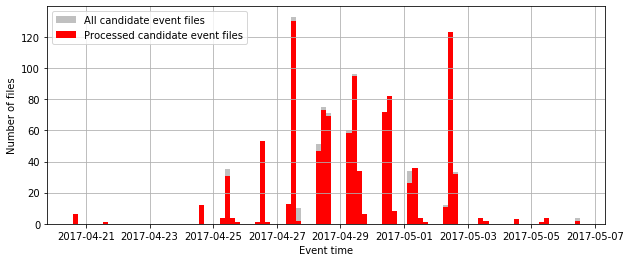

In [58]:
fig, ax = plt.subplots(figsize=(10,4))
files_df['datetime'].hist(ax=ax, bins=100, range=hist_date_range, color='silver', label='All candidate event files')
db_df['datetime'].hist(ax=ax, bins=100, range=hist_date_range, color='red', label='Processed candidate event files')
# ax.set_yscale('log')
ax.set_ylabel('Number of files')
ax.set_xlabel('Event time')
ax.legend()
fig.savefig(os.path.join(data_snippets_dir, 'num_file_distribition_date_linear.svg'))
plt.show()

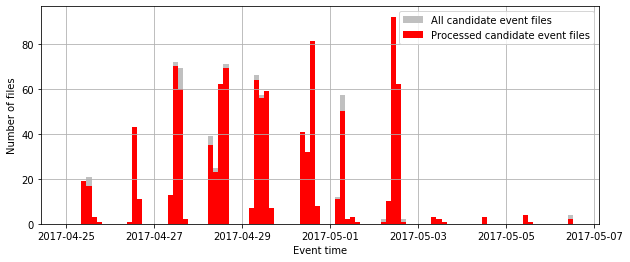

In [59]:
hist_range_modified = (start_datetime, hist_date_range[1])

fig, ax = plt.subplots(figsize=(10,4))
files_after_start_df['datetime'].hist(ax=ax, bins=100, range=hist_range_modified, color='silver', label='All candidate event files')
db_after_start_df['datetime'].hist(ax=ax, bins=100, range=hist_range_modified, color='red', label='Processed candidate event files')
# ax.set_yscale('log')
ax.set_ylabel('Number of files')
ax.set_xlabel('Event time')
ax.legend()
fig.savefig(os.path.join(data_snippets_dir, 'num_file_distribition_date_linear_from_20170425.svg'))
plt.show()

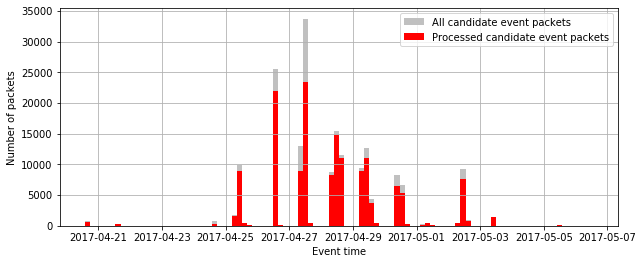

In [60]:
fig, ax = plt.subplots(figsize=(10,4))
files_df['datetime'].hist(ax=ax, weights=files_df['count'], bins=100, range=hist_date_range, color='silver', label='All candidate event packets')
db_df['datetime'].hist(ax=ax, weights=db_df['count'], bins=100, range=hist_date_range, color='red', label='Processed candidate event packets')
# ax.set_yscale('log')
ax.set_ylabel('Number of packets')
ax.set_xlabel('Event time')
ax.legend()
fig.savefig(os.path.join(data_snippets_dir, 'packet_distribition_date_linear.svg'))
plt.show()

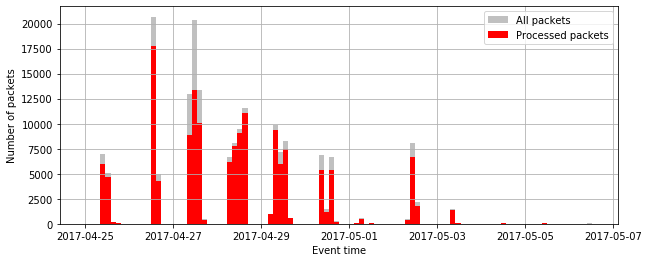

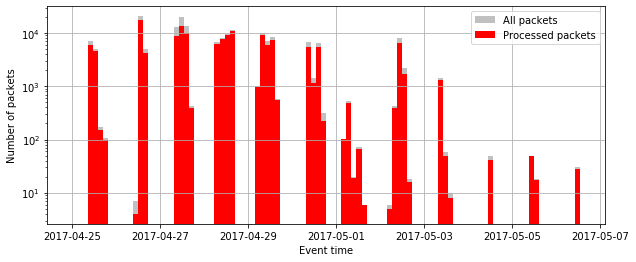

In [61]:
hist_range_modified = (start_datetime, hist_date_range[1])

for scale in ['linear', 'log']:
    fig, ax = plt.subplots(figsize=(10,4))
    files_df['datetime'].hist(ax=ax, weights=files_df['count'], bins=100, range=hist_range_modified, color='silver', label='All packets')
    db_df['datetime'].hist(ax=ax, weights=db_df['count'], bins=100, range=hist_range_modified, color='red', label='Processed packets')
    ax.set_yscale(scale)
    ax.set_ylabel('Number of packets')
    ax.set_xlabel('Event time')
    ax.legend()
    fig.savefig(os.path.join(data_snippets_dir, 'packet_distribition_date_'+scale+'_from_20170425.svg'))
    plt.show()

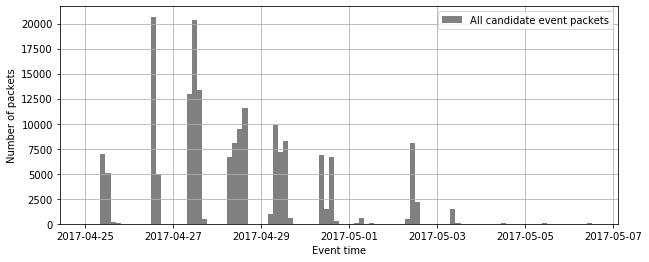

In [62]:
hist_range_modified = (start_datetime, hist_date_range[1])

fig, ax = plt.subplots(figsize=(10,4))
files_after_start_df['datetime'].hist(ax=ax, weights=files_after_start_df['count'], bins=100, range=hist_range_modified, color='gray', label='All candidate event packets')
# db_df['datetime'].hist(ax=ax, weights=db_df['count'], bins=100, range=hist_range_modified, color='red', label='Processed candidate event packets')
# ax.set_yscale('log')
ax.set_ylabel('Number of packets')
ax.set_xlabel('Event time')
ax.legend()
fig.savefig(os.path.join(data_snippets_dir, 'files_packet_distribition_date_linear_from_20170425.svg'))
plt.show()

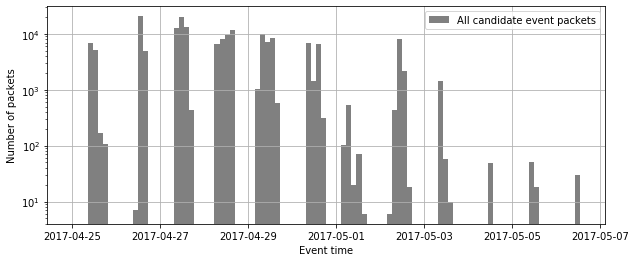

In [63]:
starting_datetime = datetime.datetime(year=2017, month=4, day=25)
hist_range_modified = (starting_datetime, hist_date_range[1])

fig, ax = plt.subplots(figsize=(10,4))
files_after_start_df['datetime'].hist(ax=ax, weights=files_after_start_df['count'], bins=100, range=hist_range_modified, color='gray', label='All candidate event packets')
# db_df['datetime'].hist(ax=ax, weights=db_df['count'], bins=100, range=hist_range_modified, color='red', label='Processed candidate event packets')
ax.set_yscale('log')
ax.set_ylabel('Number of packets')
ax.set_xlabel('Event time')
ax.legend()
fig.savefig(os.path.join(data_snippets_dir, 'files_packet_distribition_date_log_from_20170425.svg'))
plt.show()

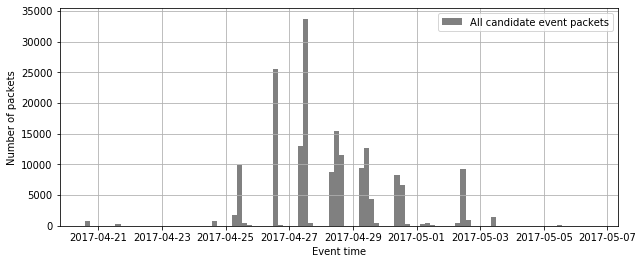

In [64]:
fig, ax = plt.subplots(figsize=(10,4))
files_df['datetime'].hist(ax=ax, weights=files_df['count'], bins=100, range=hist_date_range, color='gray', label='All candidate event packets')
# db_df['datetime'].hist(ax=ax, weights=db_df['count'], bins=100, range=hist_range_modified, color='red', label='Processed candidate event packets')
# ax.set_yscale('log')
ax.set_ylabel('Number of packets')
ax.set_xlabel('Event time')
ax.legend()
fig.savefig(os.path.join(data_snippets_dir, 'files_packet_distribition_date_linear.svg'))
plt.show()

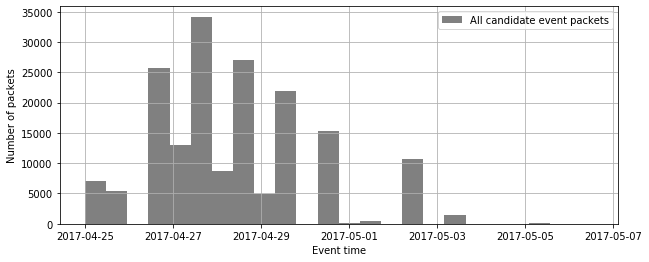

In [65]:
hist_range_modified = (starting_datetime, hist_date_range[1])

fig, ax = plt.subplots(figsize=(10,4))
files_after_start_df['datetime'].hist(ax=ax, weights=files_after_start_df['count'], bins=24, range=hist_range_modified, color='gray', label='All candidate event packets')
# db_df['datetime'].hist(ax=ax, weights=db_df['count'], bins=100, range=hist_range_modified, color='red', label='Processed candidate event packets')
# ax.set_yscale('log')
ax.set_ylabel('Number of packets')
ax.set_xlabel('Event time')
ax.legend()
# fig.savefig(os.path.join(data_snippets_dir, 'files_packet_distribition_date_log_from_20170425.svg'))
plt.show()